In [1]:
# Housing Dataset
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',
                header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS',
             'NOX', 'RM', 'AGE', 'DIS', 'RAD',
             'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


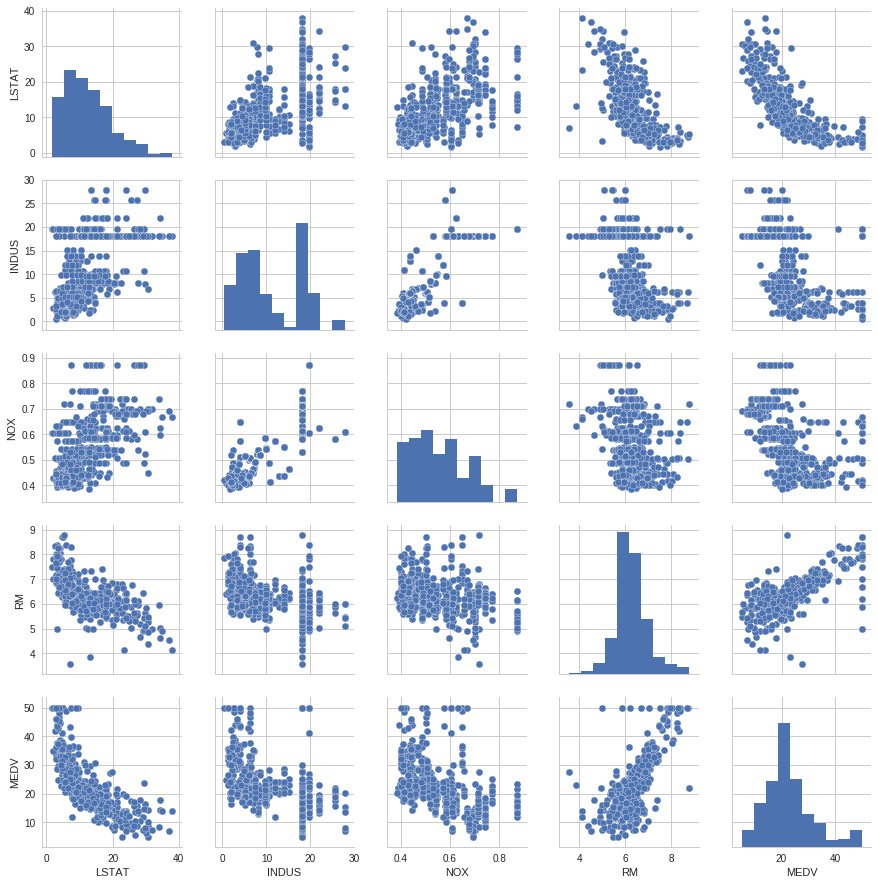

In [2]:
# Visualizing the important characteristics of a dataset

# scatterplot matrix to visualize pair-wise correlations between different features
# seaborn library - Python library for drawing statistical plots based on matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
sns.pairplot(df[cols], size=2.5);
plt.show()

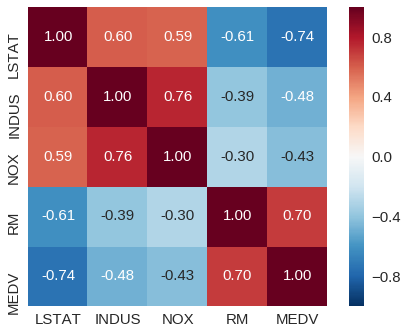

In [3]:
# Correlation Matrix 
# Contains Pearson product-moment correlation coefficients (Pearson's r), measures linear dependency between pairs
# of features.
# Bounded in range -1 and 1.
# Two features perfect positive correlation if r = 1, no correlation if r = 0 and 
# perfect negative correltaion if r = -1.
# Caclulated as covariance between two features x and y divided by the product of their standard deviation

# Plot correlation matrix as heat map:
import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 15}, yticklabels=cols, xticklabels=cols)
plt.show()

In [4]:
# Implementing ordinary least squares linear regression model (OLS)
# Estimate the parameters of the regression line that minimizes the sum of the squared vertical distances
# (residuals/errors) to the sample points.

# Solving regression for regression parameters with gradient descent

# Use RM (number of rooms) as explanatory variable to train a model that can predict MEDV (housing prices)
from linear_regression_gd import LinearRegressionGD

X = df[['RM']].values # nested array as only 1 feature per sample
y = df[['MEDV']].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)
lr = LinearRegressionGD()
lr.fit(X_std, y_std.flatten())

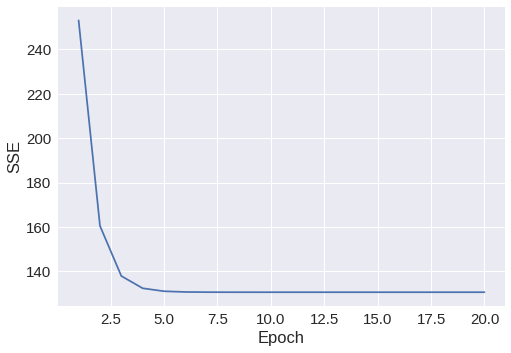

In [5]:
# Plot cost  as a function of the number of epochs (passes over the training dataset)
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [6]:
# Visualize how well the linear regression line fits the training data

# helper function
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')
    return None

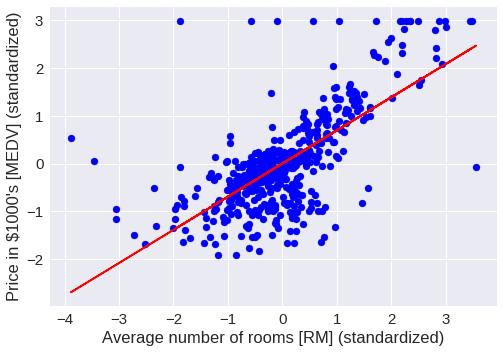

In [7]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.show()

In [8]:
# In certain cases, may need to report predicted outcome variables on original scale
num_rooms_std = sc_x.transform([[5.0]]) # house with 5 rooms
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % \
    sc_y.inverse_transform(price_std))

Price in $1000's: 10.840


In [9]:
# Note: do not have to update the weight of the intercept if working with standardied variables \
# since y intercept is always 0
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


In [10]:
# Estimating the coefficient of a regression model via scikit-learn
# LIBLINEAR library
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept:%.3f' % slr.intercept_) # unstandardized variables

Slope: 9.102
Intercept:-34.671


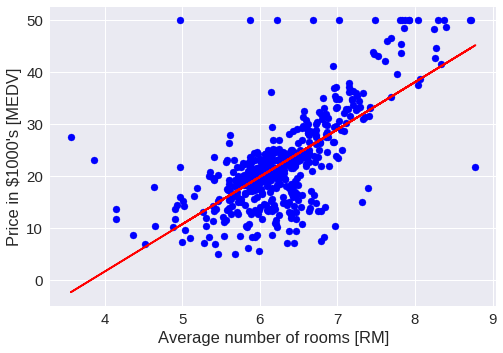

In [11]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()

In [12]:
# Fitting a robust regression model using RANSAC

# Linear regression models heavily impacted by the presence of outliers
# Random Sample Consensus (RANSAC) algorithm - fits regression model to subset of data (inliers)
# 1. Select random number of samples to be inliers and fit model
# 2. Test all other data ponts against fitted model and add those points that fall within a user-given tolerance
# to the inliers.
# 3. Refit the model using all inliers.
# 4. Estimate the error of the fitted model versus inliers
# 5. Terminate the algorithm if the performance meets a certain user-defined threshold or if a fixed number of
# iterations has been reached; go back to step 1 otherwise

from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(),
                        max_trials=100,
                        min_samples=50,
                        loss=lambda y, y_pred: np.sum(np.abs(y-y_pred), axis=1), # vertical distance btw fitted line and sample pts
                        residual_threshold=5.0, # only allow dist <= 5 from fitted line
                        random_state=0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None,
        loss=<function <lambda> at 0x7f1025c6a510>, max_trials=100,
        min_samples=50, random_state=0, residual_metric=None,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

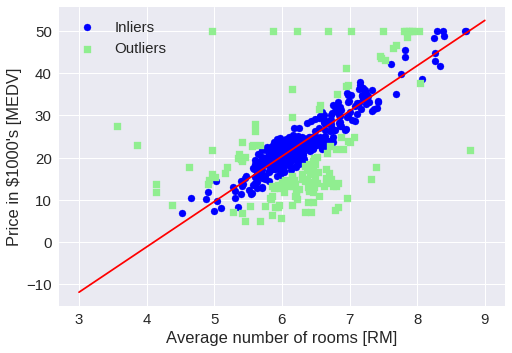

In [13]:
# plot inliers and outliers from fitted RANSAC linear regression model
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
           c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [14]:
# print slope and intercept
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


In [16]:
# Evaluating the performance of linear regression models
# Split into train and test set

# Multiple regression model
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values # all features except MEDV
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

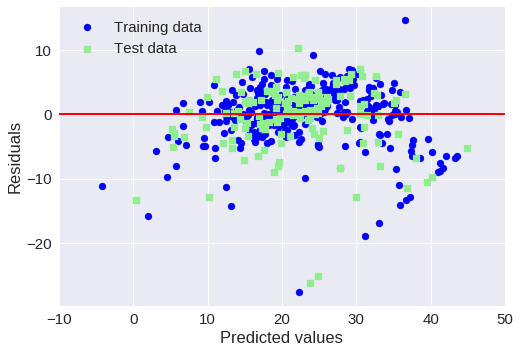

In [17]:
# residual plots
plt.scatter(y_train_pred, y_train_pred - y_train,
            c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test,
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()

In [18]:
# Mean Squared Error (MSE) as quantitative measure of model's performance
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % ( 
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196


In [19]:
# R^2 - standardized version of MSE
# R^2 is the fraction of response variance captured by model
# R^2 = 1 - SSE/SST (if R^2 == 1, model fits data perfectly)
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),
                                      r2_score(y_test, y_test_pred)))

R^2 train: 0.765, test: 0.673


In [20]:
# Regularization

# Ridge Regression
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)

# LASSO regressor
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)

# Elastic Net
from sklearn.linear_model import ElasticNet
lasso = ElasticNet(alpha=1.0, l1_ratio=0.5) #l2/l1 ratio

# more info at http://scikit-learn.org/stable/modules/linear_model.html

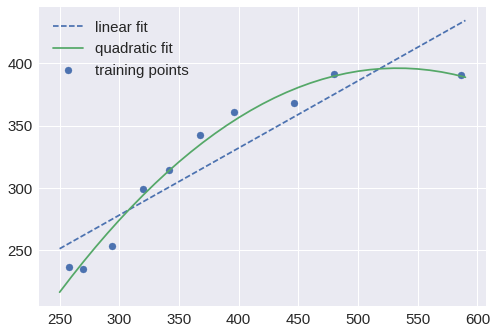

In [21]:
# Polynomial regression
# Still considered a multiple linear regression model because of linear regression coefficients (w)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Add a second degree polynomial term
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0, 270.0, 294.0,
             320.0, 342.0, 368.0,
             396.0, 446.0, 480.0,
             586.0])[:, np.newaxis]

y = np.array([236.4, 234.4, 252.8,
             298.6, 314.2, 342.2,
             360.8, 368.0, 391.2,
             390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

# Fit a simple linear regression model for comparison:
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# Fit multiple regression model on transformed features for polynomial regression
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')
plt.show()

In [22]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear: %.3f, quadratic: %.3f' % ( r2_score(y, y_lin_pred),
                                                     r2_score(y, y_quad_pred)))


Training MSE linear: 0.832, quadratic: 0.982


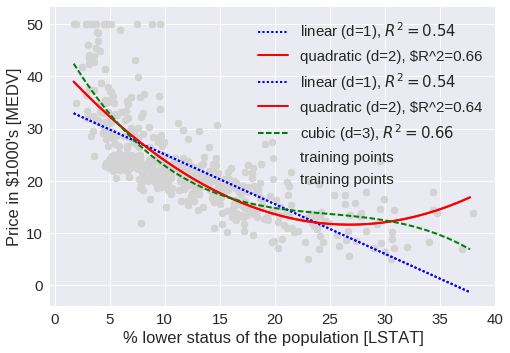

In [25]:
# Modeling nonlinear relationships in the Housing Dataset

# Model the relationship between house prices and LSTAT (percent lower status of the population) using
# 2nd degree (quadratic) and 3rd degree (cubic) polynomial

X = df[['LSTAT']].values
y = df['MEDV'].values
regr = LinearRegression()

# create polynomial features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# linear fit
X_fit = np.arange(X.min(), X.max(), 1) [:, np.newaxis]
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

# quadratic fit
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

# cubic fit
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

# plot results
plt.scatter(X, y, label='training points',
           color='lightgray')
plt.plot(X_fit, y_lin_fit,
        label='linear (d=1), $R^2=%.2f$' % linear_r2,
        color='blue',
        lw=2,
        linestyle=':')
plt.plot(X_fit, y_quad_fit,
        label='quadratic (d=2), $R^2=%.2f' % quadratic_r2,
        color='red',
        lw=2,
        linestyle='-')
plt.plot(X_fit, y_cubic_fit,
        label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
        color='green',
        lw=2,
        linestyle='--')
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')
plt.show()

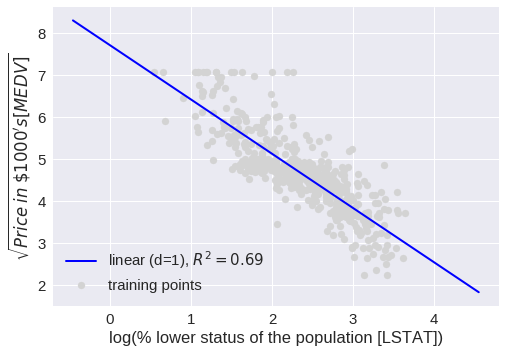

In [28]:
# Polynomial features not always best choice for modeling nonlinear relationships

# e.g. log transformation of the LSTAT feature variable and square root of MEDV followed by linear regression

# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1,
                 X_log.max()+1, 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# plot results
plt.scatter(X_log, y_sqrt,
           label='training points',
           color='lightgray')
plt.plot(X_fit, y_lin_fit,
        label='linear (d=1), $R^2=%.2f$' % linear_r2,
        color='blue',
        lw=2)
plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$')
plt.legend(loc='lower left')
plt.show()

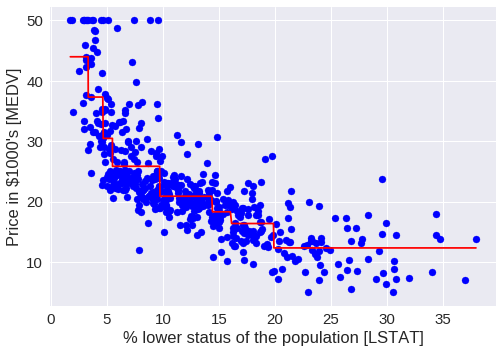

In [30]:
# Dealing with nonlinear relationships using random forests
# Ensemble of multiple decision trees - sum of piecewise linear functions - subdivide input space
# Decision tree regression
# Impurity as MSE of node in Information Gain function

# relationship between MEDV and LSTAT
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()


In [40]:
# Random forest regression
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.4,
                                                   random_state=1)

from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000,
                              criterion='mse',
                              random_state=1,
                              n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
    mean_squared_error(y_train, y_train_pred),
    mean_squared_error(y_test, y_test_pred)))

print('R^2 train: %.3f, test:%.3f' % (
    r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred)))

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test:0.878


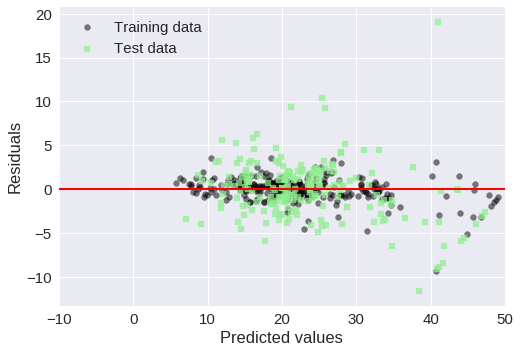

In [41]:
# Plot residuals of predicion

plt.scatter(y_train_pred,
           y_train_pred - y_train,
           c='black',
           marker='o',
           s=35,
           alpha=0.5,
           label='Training data')
plt.scatter(y_test_pred,
           y_test_pred - y_test,
           c='lightgreen',
           marker='s',
           s=35,
           alpha=0.7,
           label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()

# residuals not completely random around zero center point, may not capture all explanatory information